# import

In [1]:
import numpy as np
import pandas as pd
import ffmpeg
import os
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import ceil
import scipy.io as sio 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

D:\program\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


cuda


# load total dataset

In [2]:
if 'total_dataset' not in dir():
    with open('total_dataset.pkl','rb') as f:
        total_dataset = pickle.load(f)
file_list = {}
file_list['train'] = os.listdir('./processed1/train/')
file_list['val'] = os.listdir('./processed1/val/')

# filter dataset 0.3 0.7

In [188]:
cut = []
tmp = []
for f in file_list['train']:
    gt = total_dataset['train'][f]['gt']
    if (gt>0.7).all() or (gt<0.3).all():
        cut.append(f)
    else:
        tmp.append(f)
file_list['train'] = tmp
for c in cut:
    del total_dataset['train'][c]
    
cut = []
tmp = []
for f in file_list['val']:
    gt = total_dataset['val'][f]['gt']
    if (gt>0.7).all() or  (gt<0.3).all():
        cut.append(f)
    else:
        tmp.append(f)
file_list['val'] = tmp
for c in cut:
    del total_dataset['val'][c]

# dataloader

In [3]:
from torch.utils.data import Dataset, DataLoader

def default_loader(filename,mode):
    return total_dataset[mode][filename]

class trainset(Dataset):
    def __init__(self, mode='train', loader=default_loader):
        self.mode = mode
        self.file_list = file_list[mode]
        self.loader = loader
        
    def __getitem__(self, idx):
        res = self.loader(self.file_list[idx],self.mode) 
        return res

    def __len__(self):
        return len(self.file_list)

# model def

In [140]:
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim,isBiLSTM=False):
        super(LSTM_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,bidirectional=isBiLSTM)
        self.isBiLSTM = isBiLSTM
    def forward(self, x):
        n = 2 if self.isBiLSTM else 1
        h0 = torch.zeros(n, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(n, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return out[:,-1,:]
    
class LSTM_Model_pre(nn.Module):
    def __init__(self, input_dim, hidden_dim,isBiLSTM=False):
        super(LSTM_Model_pre, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,bidirectional=isBiLSTM)
        self.isBiLSTM = isBiLSTM
    def forward(self, x):
        n = 2 if self.isBiLSTM else 1
        h0 = torch.zeros(n, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(n, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return out
    

size = {}
size['m2'] = 576
size['m3'] = 960
size['r50'] = 2048
size['r101'] = 2048
class COMBINE(nn.Module):
    def __init__(self,fea_model='m2'):
        super(COMBINE, self).__init__()
        self.fea_model = fea_model
        if fea_model in ['r50','r101']:
            self.lstm_face_pre = LSTM_Model_pre(2048,512)
            self.lstm_face = LSTM_Model(512,256)
        
        if fea_model in ['m2','m3']:
            self.lstm_face = LSTM_Model(size[fea_model],256)
        
        self.fc_bg = nn.Linear(size[fea_model], 128)
        
        self.lstm_audio = LSTM_Model(128,64)
        self.bi_lstm_bert = LSTM_Model(768,128,True)
        self.fc_bert = nn.Linear(256, 128)
        
        self.fc_1 = nn.Linear(576, 256)
        self.bn_1 = nn.BatchNorm1d(256)
        self.relu_1 = nn.ReLU6(inplace=True)
        self.fc_2 = nn.Linear(256, 64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.relu_2 = nn.ReLU6(inplace=True)
        self.fc_3 = nn.Linear(64, 5)
        self.bn_3 = nn.BatchNorm1d(5)
        self.relu_3 = nn.ReLU6(inplace=True)
        self.dropout = nn.Dropout(0.1)
    def forward(self, face,bg,audio,bert):
        
        if self.fea_model in ['r50','r101']:
            face = self.lstm_face_pre(face)
        x_face = self.lstm_face(face)
        x_bg = self.fc_bg(bg)
        x_audio = self.lstm_audio(audio)
        x_bert = self.bi_lstm_bert(bert)
        x_bert = self.fc_bert(x_bert)
#         print([x_face.shape,x_bg.shape,x_audio.shape,x_bert.shape])
        x = torch.cat([x_face,x_bg,x_audio,x_bert],1)
#         x = x_face
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        x = self.fc_3(x)
#         x = self.bn_3(x)
#         x = self.relu_3(x)
#         x = self.dropout(x)
        return x


model = COMBINE('r50')
face,bg,audio,bert = torch.randn(32,12,2048),torch.randn(32,2048),torch.randn(32, 12, 128),torch.randn(32, 90, 768)
x = model(face,bg,audio,bert)
x.shape

576


torch.Size([32, 5])

# set train

In [141]:
train_data = trainset('train')
val_data = trainset('val')
BATCH_SIZE = 64
EPOCH_N = 100
alpha = 0.7
fea_model = 'm3'
rank_type = 'cos'

model = COMBINE(fea_model).to(device)
loss_mse = nn.MSELoss()
loss_mae = nn.L1Loss()
loss_rank = nn.CosineEmbeddingLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = None


LR_REC = []
LOSS_REC_T = []
t_n = ceil(len(train_data)/BATCH_SIZE)
v_n = ceil(len(val_data)/BATCH_SIZE)
epoch_loss = np.zeros((EPOCH_N,7))
epoch_idx = 0
val_loss = 100

In [6]:
def top_k_acc(res,gt,k):
    N = res.shape[0]
    res_s = np.argsort(res,axis=1)[:,::-1]
    gt_s = np.argsort(gt,axis=1)[:,::-1]
    tmp = 0
    for i in range(N):
        if gt_s[i,0] in res_s[i,:k]:   #  top-k 
            tmp+=1
    return tmp/N

posi_factor = 1/(np.log(np.array([1,2,3,4,5])+1)/np.log(2))
def DCG(res_s,gt_s):
    res = 0
    for i in range(5):
        in_gt_idx = list(gt_s).index(res_s[i])
        res += (5-in_gt_idx)*posi_factor[i]
    return res

def loss_rank_dcg(res,gt):
    res = res.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()
    
    N = res.shape[0]
    res_s = np.argsort(res,axis=1)[:,::-1]
    gt_s = np.argsort(gt,axis=1)[:,::-1]
    tmp = 0
    for i in range(N):
        dcg = DCG(res_s[i,:],gt_s[i,:])
        tmp += (1-dcg/10.272)
    return torch.tensor(tmp/N)

def train_epoch(model, optimizer, scheduler=None, train_mode=True, istqdm=True):
    global epoch_idx,val_loss
    if train_mode:
        dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
        model.train()
    else:
        dataloader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
        model.eval()   
    if istqdm:
        dataloader = tqdm(dataloader)
    
    
   
    batch_loss_tmp = np.zeros((v_n,7))
    for idx,x in enumerate(dataloader):
        optimizer.zero_grad()
        with torch.set_grad_enabled(train_mode):
            res = model(x['face_'+fea_model].float().to(device),x['bg_'+fea_model].float().to(device),
                        x['audio'].float().to(device),x['bert'].float().to(device))
        x_gt = x['gt'].float().to(device)

        mse_loss = loss_mse(res,x_gt).to(device)
        mae_loss = loss_mae(res,x_gt).to(device)

        if rank_type == 'cos':
            target = torch.ones(res.shape[0]).to(device)
            rank_loss = loss_rank(res,x_gt,target).to(device)
        elif rank_type == 'dcg':
            rank_loss = loss_rank_dcg(res,x_gt).to(device)
        
        
        loss = alpha*rank_loss+(1-alpha)*mse_loss
        
        if train_mode:
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step() 
            LOSS_REC_T.append(loss.item())
            LR_REC.append(optimizer.state_dict()['param_groups'][0]['lr'])
        else:
            batch_loss_tmp[idx,0] = loss.item()
            batch_loss_tmp[idx,1] = 1-mae_loss.item()
            batch_loss_tmp[idx,2] = mse_loss.item()
            batch_loss_tmp[idx,3] = rank_loss.item()
            batch_loss_tmp[idx,4] = top_k_acc(res.detach().cpu().numpy(),x_gt.detach().cpu().numpy(),1)
            batch_loss_tmp[idx,5] = top_k_acc(res.detach().cpu().numpy(),x_gt.detach().cpu().numpy(),2)
            batch_loss_tmp[idx,6] = top_k_acc(res.detach().cpu().numpy(),x_gt.detach().cpu().numpy(),3)
            
            if loss.item()<val_loss:
                val_loss = loss.item()
                torch.save(model.state_dict(), 'best_model.pt')
#                 print(epoch_idx)
            
    if train_mode == False:   # save each epoch
        epoch_loss[epoch_idx,:] = np.mean(batch_loss_tmp,0)
        batch_loss_tmp = np.zeros((v_n,7))
        epoch_idx+=1
    return

# do train

In [142]:
for e in tqdm(range(EPOCH_N)):
    train_epoch(model, optimizer, scheduler, train_mode=True, istqdm=False)
    train_epoch(model, optimizer, scheduler, train_mode=False, istqdm=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.57s/it]


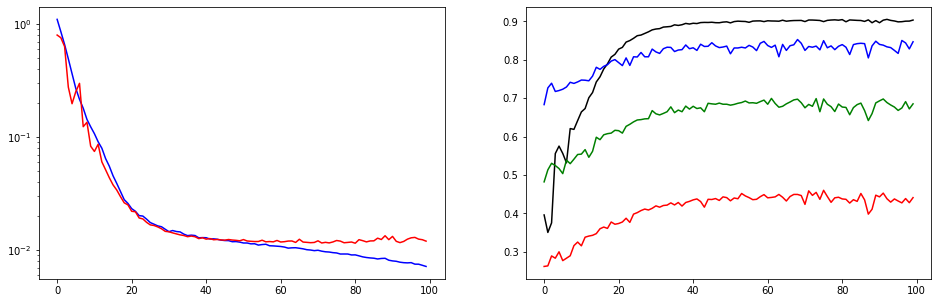

In [143]:
def epoch_mean(tmp,num):
    return [np.mean(tmp[i*num:(i+1)*num]) for i in range(len(tmp)//num)]

t_n = ceil(len(train_data)/BATCH_SIZE)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epoch_mean(LOSS_REC_T,t_n),'b-')
plt.plot(epoch_loss[:,0],'r-')
# plt.plot(epoch_loss[:,3],'g-')
plt.yscale('log')
plt.subplot(1,2,2)
plt.plot(epoch_loss[:,1],'k-')
plt.plot(epoch_loss[:,4],'r-')
plt.plot(epoch_loss[:,5],'g-')
plt.plot(epoch_loss[:,6],'b-')

savepath = 'b'+str(BATCH_SIZE)+'_'+str(EPOCH_N)+'epoch_alpha'+str(alpha)+'_'+fea_model+'_'+rank_type+'.mat'
sio.savemat(savepath,{'ori_train_loss':LOSS_REC_T,'train_loss':epoch_mean(LOSS_REC_T,t_n),'epoch_loss':epoch_loss})